# Plagiarism & Hashing]
Finn Macken

# Version One: Rolling Hashing

In [1]:
class HashNode:
    def __init__(self, key, value, startingindex, nextnode = None, prevnode = None):
        """
        This class is a representation of a hash key value pair, with more attributes
        and methods for increased functionality
        
        Parameters
        ----------
        self.key: int
            the hash key associated with the node
        self.value: str
            the substring from which the hash was generated
        self.nextnode: HashNode
            a pointer variable which contains the next hashnode in a chain
        self.startingindex: int
            the index in the associated string at which the substring began
        """
        self.key = key
        self.value = value
        self.nextnode = nextnode
        self.startingindex = startingindex
        
    def __repr__(self):
        """
        The string representation of the HashNode
        """
        return f'({self.key}, {self.value}, {self.startingindex}), next: [{self.nextnode}]'

class HashTable:
    def __init__(self):
        """
        This class implements a hash table that can be used to solve the string
        matching problem, and which uses rolling hashing to compute hashes
        
        Parameters
        ----------
        self.table: array
            array used to implement a hash table
        self.base: int
            the base that each hash code is in
        self.q: int
            the divisor used in the hash function -- dynamic value
        self.prime: int
            the prime used in the second hash function in double hashing
        self.hash_method: self.rolling_hashify OR self.static_hashify
            the method used to compute hash values from substring inputs
        self.collisions: int
            # of collisions that occurred when constructing hash table
        """
        self.table = []
        self.base = 7
        self.q = 7
        self.prime = 21
        self.hash_method = self.rolling_hashify
        self.collisions = 0
        
    def clean_string(self, string):
        """
        Processes an input string so that it's suitable for hashing. Removes
        spaces and special characters and converts upper case to lower case.

        Parameters
        ---------
        string: str
            input string

        Output
        ---------
        new_string: str
            processed version of input string
        """
        new_string = string.lower()
        
        # remove all illegal characters from the input string
        bad_characters = ".,\/ ;"
        for char in bad_characters:
            new_string = new_string.replace(char, '')
        new_string = new_string.replace('"', '')
        new_string = new_string.replace("'", "")
        return new_string

    def ascii_sum(self, string):
        """
        Converts the given string into an integer using ASCII code conversion, 
        for use in hashing

        Parameters
        ----------
        string: str
            The string to be converted
        
        Outputs
        ----------
        ascii_sum: int
            an ascii sum representation of the input string
        """
        
        
        ascii_sum = 0
        exp_value = len(string)-1
        
        # creates a hash value by raising a char's ascii code to its word position
        for char in string:
            ascii_sum += ord(char)*(self.base**exp_value)
            exp_value -= 1
        return ascii_sum
    
    
    def rolling_hash(self, old_str, old_hash, new_char):
        """
        Implements a rolling hash algorithm, where an old hash
        is used to calculate a new hash
            
        Parameters
        ----------
        old_str: str
            The previous string from which the hash was calculated
        old_hash: int
            The previous output of the hash function
        new_char: str
            The new character to be added
           
        Output
        ------
        final_hash: int
            the new hash obtained from the old hash and the new character
        """
        # numeric representation of appending new_char to the word
        append_hash = old_hash*self.base + ord(new_char) % self.q

        # numeric represetation of removing the first character from the word
        final_hash=((append_hash-ord(old_str[0])*(self.base**len(old_str)))%self.q)%self.q
        return final_hash
        
    def rolling_hashify(self, input_string, substring_length):
        """
        Takes an input string and returns a list containing all keys
        and values provided after hashing all substrings of length m
        using a rolling hash method

        Parameters
        ---------
        string: str
            The input string
        substring_length: int
            the length of all substrings to be extracted from the input string
        
        Output
        ------
        hash_outputs: lst of tuples
            list of all keys, values and starting indexes of substrings
        """
        # preprocess the string to remove illegal characters
        string = self.clean_string(input_string)

        # create a list to store all substrings
        hash_outputs = []

        # set variables for substring indexing
        n = len(string)
        m = substring_length
        k = 0 # iterator variable
    
        # compute the value of the first hash and string of length m
        recent_hash = self.ascii_sum(string[k:k+m]) % self.q

        # store the values that we just found
        recent_string = string[k:k+m]
        hash_outputs.append((recent_hash, string[k:k+m], k))
        k += 1

        # iterate through the string to find/store all substrings of length m
        while k <= n - m:
            new_hash = self.rolling_hash(recent_string,recent_hash, string[k+m-1])
            hash_outputs.append((new_hash, string[k:k+m], k))
            
            # overwrite/increment all variables for the next calculation
            recent_hash = new_hash
            recent_string = string[k:k+m]
            k += 1
        return hash_outputs
    
    def insert(self, hashnode):
        """
        Inserts a HashNode at a given index, dealing with
        collisions through double hashing and duplicates through
        chaining
        
        Parameters
        ---------
        hashnode: HashNode
            The hash key value pair to be inserted
            
        Outputs
        --------
        None
        """
        
        index = hashnode.key
        
        # increase the table size if it's too small for the index
        if index >= len(self.table):
            none_list = [None for i in range(len(self.table), index+2)]
            self.table.extend(none_list)
        
        # if there are no collisions
        if self.table[index] == None:
            self.table[index] = hashnode
        
        # if there's a collision
        elif type(self.table[index]).__name__ == "HashNode":
            self.collisions += 1
            
            # deals with duplicate cases using the chaining approach
            if self.table[index].value == hashnode.value:
                node = self.table[index]
                while node.nextnode != None:
                    node = node.nextnode
                node.nextnode = hashnode
            
            # deals with other cases using double hashed open addressing
            else:
                i = 1
                
                while type(self.table[index]).__name__ == "HashNode":
                    self.collisions += 1
                    
                    # perform secondary hashing to find a new index
                    index = index % 31 +i*(self.prime - index % self.prime)
                    i += 1
                    
                    # if the new index is larger than the table, extend the table
                    if index >= len(self.table):
                        none_list = [None for i in range(len(self.table), index+1)]
                        self.table.extend(none_list)
            
                if index < len(self.table):
                    self.table[index] = hashnode
                else:
                    return "Table Extension Error"
        else:
            return "Chain Insert Error"

    def create_hash_table(self, string, substring_length, verbose = True):
        """
        Creates a hash table given a set of keys and values

        Parameters:
        -----------
        string: str
            the input string from which the hash table is constructed
        substring_length: int
            the length of the substrings to be found in string
        verbose: Boolean
            A switch variable; when True, reports the load factor of the table

        Outputs
        ----------
        hash_table: lst
            A hash table, represented through a Python list
        """
        # get all hash key value pairs
        hash_outputs = self.hash_method(string, substring_length)

        # insert key value pair nodes into the hash table
        for hashterm in hash_outputs:
            node = HashNode(key = hashterm[0], 
                            value = hashterm[1], 
                            startingindex = hashterm[2])
            self.insert(node)
        
        
        # calculate the load factor of the table
        if verbose == True:
            load_factor = len(hash_outputs)/len(self.table)
            print(f"The load factor is: {round(load_factor, 3)}")
        
        return self.table
        
    def compare_substrings(self, x, y, substring_length, 
                           debug = False, verbose = True,
                           xswitch = False, collision_count = False):
        """
        Finds common substrings in x and y of length substring_length
        
        Parameters
        ----------
        x: str
            the first string to be compared
        y: str
            the second string to be compared
        substring_length: int
            length of the substrings to be found
        debug: Boolean
            switch variable; when True, returns the list of key-value pairs for debug
        verbose: Boolean
            switch variable; when True, reports the load factor of the hash table
        xswitch: Boolean
            switch variable; when True, returns x's hash table instead of matches
        collision_count: Boolean
            switch variable; when True, returns the # of collisions instead of matches
        """
        
        if type(x) != str or type(y) != str:
            return "x and y must both be strings"
        
        # reset table for new calculation
        self.table = [None]
        
        # compute an appropriate q given input sizes
        maxlen = len(x)
        # the number of non-empty substrings is n*(n+1)//2
        calcval = (maxlen*(maxlen+1)//2)//2
        if calcval == 0: # this only occurs if the table is empty
            self.q = 7 # this could be anything
        else:
            self.q = calcval
        
        
        matches = [] # container variable to hold all matched substrings
        
        # create a hash table for x
        xtable = self.create_hash_table(x, substring_length, verbose)
    
        # find all substrings in y of the appropriate length
        yhashes = self.hash_method(y, substring_length)
        
        # for each substring, check if there's a match
        for hashtuple in yhashes:
            hashindex = hashtuple[0]
            hashstring = hashtuple[1]
            
            if hashindex < len(xtable):
                if xtable[hashindex] != None:
                    
                    node = xtable[hashindex]
                    
                    # if it's the string we want, return it and all duplicates
                    if node.value == hashstring:                        
                        # get all duplicates
                        while node != None:
                            matches.append((hashtuple[1], node.startingindex, hashtuple[2]))
                            node = node.nextnode
                    
                    # if it's not, continue searching until the end of the table
                    else:
                        i=1
                        while hashindex < len(xtable):
                            
                            # compute the next index it might be at
                            hashindex = hashindex % 31 + i *(self.prime-hashindex%self.prime)
                            
                            # if you find any node, check it
                            if hashindex < len(xtable):
                                if xtable[hashindex] != None:
                                    if xtable[hashindex].value == hashstring:

                                        node = xtable[hashindex]
                                        
                                        # get all duplicates
                                        while node != None:
                                            if node not in matches:
                                                matches.append((hashtuple[1], node.startingindex, hashtuple[2]))
                                            node = node.nextnode

                                        break
                                else: # increment if it's not the node we're looking for
                                    i+=1
                            else: # if you hit an empty slot, the string isn't there -- break the loop
                                break
                            
        # deals with the case where the input is empty strings
        if matches == [('', 0, 0)]:
            return []
        
        if debug == True:
            return self.rolling_hashify(x, substring_length)
        
        elif xswitch == True:
            return xtable
        
        elif collision_count == True:
            return self.collisions
        
        else:
            return matches

# Tests

The load factor is: 0.159
The load factor is: 0.023
The load factor is: 1.0
The load factor is: 1.0
The load factor is: 1.0
The load factor is: 0.003


[]

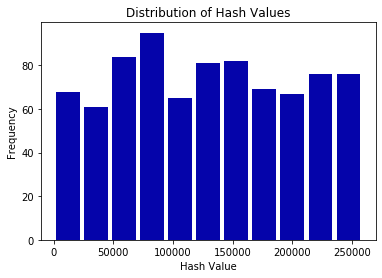

In [19]:
import matplotlib.pyplot as plt

hashtable = HashTable()

# Test 1: Simple Test
x = "Today is Monday'"
y = 'today'
assert hashtable.compare_substrings(x, y, 3) == [('tod', 0, 0), ('oda', 1, 1), ('day', 2, 2), ('day', 10, 2)]

# Test 2: Plagiarism Detection
x = "I had an original idea: hash tables can detect plagiarism."
y = "In part one of this assignment, I showed that hash tables can detect plagiarism"
assert hashtable.compare_substrings(x, y, 29) == [('hashtablescandetectplagiarism', 19, 36)]

# Test 3: Edge Cases
x = ""
y = ""
assert hashtable.compare_substrings(x, y, 3) == []

x = ',.;/'
y = ""
assert hashtable.compare_substrings(x, y, 1) == []

x = " "
y = " "
assert hashtable.compare_substrings(x, y, 1) == []

x = 1
y = 2
assert hashtable.compare_substrings(x, y, 1) == "x and y must both be strings"

# OTHER TESTS
# Uniformity of distribution Test 1
x = "In computing, a hash table (hash map) is a data structure that implements an associative array abstract data type, a structure that can map keys to values. A hash table uses a hash function to compute an index, also called a hash code, into an array of buckets or slots, from which the desired value can be found. During lookup, the key is hashed and the resulting hash indicates where the corresponding value is stored. Ideally, the hash function will assign each key to a unique bucket, but most hash table designs employ an imperfect hash function, which might cause hash collisions where the hash function generates the same index for more than one key. Such collisions are typically accommodated in some way. In a well-dimensioned hash table, the average cost (number of instructions) for each lookup is independent of the number of elements stored in the table. Many hash table designs also allow arbitrary insertions and deletions of key–value pairs, at (amortized[2]) constant average cost per operation.[3][4]"
y = "A basic requirement is that the function should provide a uniform distribution of hash values. A non-uniform distribution increases the number of collisions and the cost of resolving them. Uniformity is sometimes difficult to ensure by design, but may be evaluated empirically using statistical tests, e.g., a Pearson's chi-squared test for discrete uniform distributions.[6][7]"

indexes = []
hashtuples = hashtable.compare_substrings(x, y, 10, debug = True)
for tup in hashtuples:
    indexes.append(tup[0])

plt.hist(indexes, bins = 'auto', color='#0504aa',rwidth=0.85)
plt.xlabel("Hash Value")
plt.ylabel("Frequency")
plt.title("Distribution of Hash Values")
plt.plot()

x: Z22{7k4aS-5/EeGvJ[%R$A]_@VZ)NN1,S|osedRw}Ul=OlP=\_Vn,\OJ,1hYJjEcJRmJ^CJg`~'b&,,xf4ArgDU,7a*<l';Lq:ZgA3;AOE8Fh.:NZZJf@%V6dSjk=^'|tskwn'3#`s?;8tp[em^?1[
y: +Lu;Jo-a(GS[?T3doEo6By]*KLg>,lnVYH{>_QObWkti$oy$SzB'oSgO.aP6}@\.6g@mqsaD"Gk`ZMq`~qJ'`:Tg;iJiMs3.\}V8c~,{LrJa}PnM}]a-jKs,6I'w7Tt&7~.Gr7qEGSfL9qASMt$I@\
The load factor is: 0.022


[]

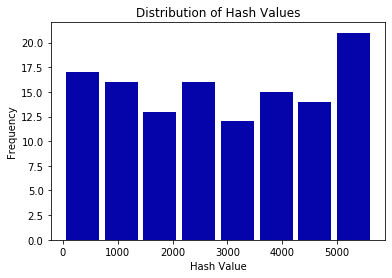

In [3]:
# Uniformity of distribution Test 2
import string
import random

chars = 150
x = "".join(random.choices(string.ascii_letters + 
                                       string.punctuation + 
                                       string.digits,
                                       k = chars))
y = "".join(random.choices(string.ascii_letters + 
                                       string.punctuation + 
                                       string.digits,
                                       k = chars))

print("x:", x)
print("y:", y)

indexes = []
hashtuples = hashtable.compare_substrings(x, y, 10, debug = True)
for tup in hashtuples:
    indexes.append(tup[0])

plt.hist(indexes, bins = 'auto', color='#0504aa',rwidth=0.85)
plt.xlabel("Hash Value")
plt.ylabel("Frequency")
plt.title("Distribution of Hash Values")
plt.plot()


The load factor is: 0.083


[]

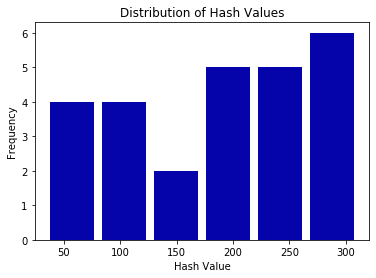

In [4]:
# Uniformity of distribution Test 3
x = '123456789abcdefghijklmnopqrstuvwxyz'
y = '123456789abcdefghijklmnopqrstuvwxyz'

indexes = []
hashtuples = hashtable.compare_substrings(x, y, 10, debug = True)
for tup in hashtuples:
    indexes.append(tup[0])

plt.hist(indexes, bins = 'auto', color='#0504aa',rwidth=0.85)
plt.xlabel("Hash Value")
plt.ylabel("Frequency")
plt.title("Distribution of Hash Values")
plt.plot()

# Test Reflections
These tests demonstrate that the algorithm performs well for many different inputs, including edge cases, small inputs, and larger inputs.  I show that the distribution of hash values for several different inputs (including the same strings, and strings composed of randomly chosen characters) is uniform, decreasing the probability of collision. I also calculate the load factor for each of my test cases, and find that it's consistently much lower than 1.

# Algorithmic Design Justifications

## Size of the Hash Table
The most interesting component of the hash table that I built is that it sizes itself dynamically as it computes substring hashes, with a goal of allotting enough slots to prevent collisions without being unnecessarily large.

The underlying principle is that the choice of ``mod q`` in the hash function changes the number of indices that the resulting hash function generates. The only way to have the ability to generate indices for the entire table is to set ``q`` equivalent to table size. This creates a serious problem when using double hash open addressing (which is what I use here to prevent clustering), because unless the table is ridiculously large, you very quickly generate indexes that are larger than the table size.

To solve this problem, I made two algorithmic decisions. First, I set ``q`` to the number of substrings that could be formed from the provided string. For ``len(x) = n``, this is ``n*(n+1)//``. Then, I built a dynamically adjusting table, which increases its size to accomodate any indices which are larger than it.

This means that the algorithm sorts out the table size such that it's not any larger than it needs to be, given the hash functions that have been implemented. At the same time, it adjusts the number of hash function outputs based on what the input size: a string of length 10 will result in far fewer indices than a string of length 100.

As I discuss in the data structures section, I also employ linked lists to manage duplicates and keep overall table size small.

## The Hash Function
I employ two hash functions in this first implementation of my code. Each substring is first given a hash value using rolling hashing and an ascii code sum, wherein the previous hash value is used to calculate the next hash value to save. calculation time.

In the case of collision, the hash value is recalculated using the sum of the same hash function employed previously and a new hash function multiplied by an iteration counter. As described above, the parameter of the first hash function ``q`` is designed to minimise the number of collisions while keeping table size small, by setting it equal to the estimated table size. The second hash function is designed so that it always returns a positive integer smaller than ``q`` (inspired by Ha and Quang's implementation in the help guide).

These decisions are designed to fulfil four main criteria: the hash function uses all input data of the string, it generates different hash values for similar strings, it is fully determined by the input data, and it closely approximates a uniform distribution, as we can see in the histograms produced in the tests above. An approximately uniform distribution is essential because it minimises the number of collisions, decreasing time complexity.

## Data Stuctures
My algorithmic strategy employs three main data structures: an array to hold hash table values, a linked list system implemented through the use of pointer attributes in the HashNode class, and a class to structure the algorithm.

I chose an array for the hash table because its designed for iteration and indexing (which I do extremely frequently in my algorithm), and isn't built on top of an existing hash table (e.g. dictionaries and sets). In addition, array data points are stored next to each other in memory (unlike in a linked list system), which makes recall faster when indexing and iterating. The main downside of an array structure is that they have a fixed length. Above, I describe how I address this issue using dynamic table extension.

In my algorithm, I use a linked list system to store copies of the same substring that occur at different indices. This has the advantage that copies of the same data are stored in the same place, keeping table size small and making some searches more efficient. For example, if you wanted to check all instances of a repeated substring, a normal open addressed hash table would require you to iterate through all indexes where the hash value is stored, making you parse through lots of extraneous data points that happen to have the same hash. In the system I built, you only have to find one index with the specified substring, and all instances of that substring are stored there.

Finally, I used a Python class to structure my algorithm. This had many advantages. First, it allowed me to make several global attributes (``q``, ``base``, ``prime``, etc.) available to all methods, while constraining them within the class. This massively decreased the number of arguments in each method, and ensured consistency across methods while developing. This also allowed for inheritance for part two of this assignment, allowing me to re-use most of the code that I'd previously written and preventing discrepancies between the two versions.

# Version Two: Static Hash Function

## Finding an effective hash function
Effective hash functions must have several characteristics:
1. **Outputs must be fully determined by the data being hashed**: hash functions always have to give the same output for the same input, which means that only the data should be used to calculate the output. If ``a == b`` doesn't imply ``hash(a) == hash(b)``, then you can't use hash values to look up values in a table accurately, because you can't be guaranteed that ``table[hash(a)] == table[hash(b)]``.

2. **The function should use all of the data to compute the output**: hash functions become ineffective when many different inputs produce the same output. This happens far more frequently when only a subset of the input is used to compute the output. For example, if you only look at the first five characters of a string to compute a hash, then all web urls will have the same hash value, leading to a massive number of collisions.

3. **The function should uniformly distribute the data across the hash table**: this is required to avoid collisions, because non-uniform distributions lead to clustering, where several datapoints have the same hash-value. This decreases the efficiency of the hash function, because you have to compute and execute some strategy for resolving these collisions.

For part two of this assignment, I decided to use the the ``APHash`` function created by Arash Partow, because its uniform qualities have already been extensively tested and it's based on decades of work on hash functions. It's a hybrid rotative and additive hash function, which takes a number in base sixteen and then raises it to the power of itself after bit shifting it using several prime numbers. As with many complicated hash functions, there's no formal proof for how its structure produces a uniform distribution. Instead, we can confirm its properties empirically:
1. The function iterates through all of the characters of the input, incorporating them all into the final hash value
2. The output is fully determined by the input -- no other values are used to calculate hashval
3. The function uniformly distributes the data. The three graphs plot the distribution of the hash values of random character strings for different p-values. Across all three, we can see that the hash function is producing approximately uniform distributions, indicating that it's likely to be effective

In [5]:
def APHash(key):
    """
    Hash function which uses addition and rotation of a base sixteen number to create an output
    
    Parameters
    ----------
    key: str
        the string from which the hash value is calculated
    
    Output
    ------
    hashval: int
        the hash value calculated from the input string
    """
    hashval = 0xAAAAAAAA # number in base sixteen
    for i in range(len(key)):
        if ((i & 1) == 0):
            # bitwise rotation using primes
            hashval ^= ((hashval <<  7) ^ ord(key[i]) * (hashval >> 3))
        else:
            # bitwise rotation using primes
            hashval ^= (~((hashval << 11) + ord(key[i]) ^ (hashval >> 5)))
    return hashval

### Plotting the distribution of hash values [Test 1: Random Characters, Small q]

[]

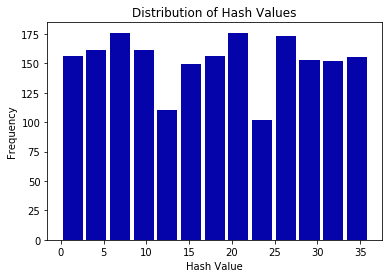

In [6]:
import string
import random
import matplotlib.pyplot as plt

hash_values = []
for i in range(1, 100):
    for j in range(20):
        chars = i
        random_string = "".join(random.choices(string.ascii_letters + 
                                       string.punctuation + 
                                       string.digits,
                                       k = chars))
        hash_values.append(APHash(random_string) % 37)

plt.hist(hash_values, bins = 'auto', color='#0504aa',rwidth=0.85)
plt.xlabel("Hash Value")
plt.ylabel("Frequency")
plt.title("Distribution of Hash Values")
plt.plot()

### Plotting the distribution of hash values [Test 2: Random Characters, Medium q]

[]

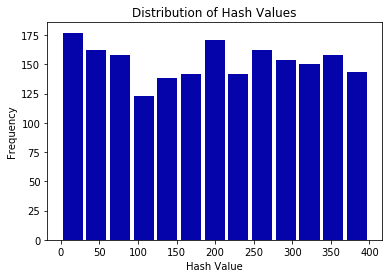

In [7]:
# Plotting the distribution of hash values [Test 1]

hash_values = []
for i in range(1, 100):
    for j in range(20):
        chars = i
        random_string = "".join(random.choices(string.ascii_letters + 
                                       string.punctuation + 
                                       string.digits,
                                       k = chars))
        hash_values.append(APHash(random_string) % 400)

plt.hist(hash_values, bins = 'auto', color='#0504aa',rwidth=0.85)
plt.xlabel("Hash Value")
plt.ylabel("Frequency")
plt.title("Distribution of Hash Values")
plt.plot()


### Plotting the distribution of hash values [Test 3: Random Characters, Large q]

[]

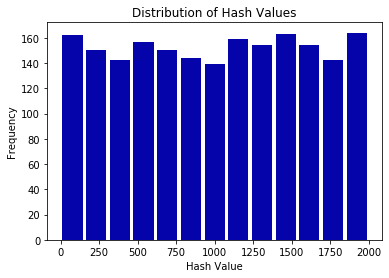

In [8]:
hash_values = []
for i in range(1, 100):
    for j in range(20):
        chars = i
        random_string = "".join(random.choices(string.ascii_letters + 
                                       string.punctuation + 
                                       string.digits,
                                       k = chars))
        hash_values.append(APHash(random_string) % 2000)

plt.hist(hash_values, bins = 'auto', color='#0504aa',rwidth=0.85)
plt.xlabel("Hash Value")
plt.ylabel("Frequency")
plt.title("Distribution of Hash Values")
plt.plot()

In [9]:
class HashTableV2(HashTable):
    def __init__(self):
        """
        This class implements a hash table which calculates hashes without
        rolling hashing
        
        Parameters (inherited from HashTable)
        self.table: array
            array used to implement a hash table
        self.base: int
            the base that each hash code is in
        self.q: int
            the divisor used in the hash function -- dynamic value
        self.prime: int
            the prime used in the second hash function in double hashing
        self.hash_method: self.rolling_hashify OR self.static_hashify
            the method used to compute hash values from substring inputs
        self.collisions: int
            # of collisions that occurred when constructing hash table
        """
        super().__init__()
        self.hash_method = self.static_hashify
    
    def APHash(self, key):
        """
        Hash function which uses addition and rotation of a base sixteen number 
        to calculate a hash value
    
        Parameters
        ----------
        key: str
            the string from which the hash value is calculated
    
        Output
        ------
        hashval: int
            the hash value calculated from the input string
        """
        hashval = 0xAAAAAAAA # number in base sixteen
        for i in range(len(key)):
            if ((i & 1) == 0):
                # bitwise rotation using primes
                hashval ^= ((hashval <<  7) ^ ord(key[i]) * (hashval >> 3))
            else:
                # bitwise rotation using primes
                hashval ^= (~((hashval << 11) + ord(key[i]) ^ (hashval >> 5)))
        return hashval
        
    def static_hashify(self, input_string, substring_length):
        """
        Takes an input string and returns a list containing all keys
        and values provided after hashing all substrings of length m
        without using rolling hashing

        Parameters
        ---------
        intput_string: str
            The input string
        substring_length: int
            the length of all substrings to be extracted from the input string
        
        Output
        ------
        hash_outputs: lst of tuples
            list of all keys, values and starting indexes of substrings
        """
        
        # preprocess the string to remove illegal characters
        string = self.clean_string(input_string)

        # create a list to hold all substrings of the given string
        hash_outputs = []

        n = len(string)
        m = substring_length
        # for substrings of the set length
        k = 0
    
        # compute and store the value of all hashes
        while k <= n - m:
            hashval = self.APHash(string[k:k+m]) % self.q
            hash_outputs.append((hashval, string[k:k+m], k))
            k += 1
            
        return hash_outputs

# Functionality Example
This algorithm detects plagiarism by identifying common substrings that are greater than or equal to a certain length, and then flagging them as possible instances of plagiarism. In the example below, it detects the phrase "I'm certain that hash tables can detect plagiarism" as a possible case of plagiarism, by looking for common substrings greater than twenty characters and less than 50 (a somewhat arbitrary range, albeit of a length where single matches should indicate the presence of plagiarism).


In [10]:
x = "I had an original idea: I'm certain that hash tables can detect plagiarism."
y = "In part one of this assignment, I showed that I'm certain that hash tables can detect plagiarism"

example = HashTableV2()

for substring_length in range(20, 50):
    if example.compare_substrings(x, y, 
                                  substring_length, 
                                  verbose=False) != []:
        print(f"Matches Found for strings of length {substring_length}")
    if len(example.compare_substrings(x, y, 
                                      substring_length,
                                      verbose = False)) == 1:
        print("Long Match Found")
        print(example.compare_substrings(x, y, 
                                         substring_length, 
                                         verbose = False))


Matches Found for strings of length 20
Matches Found for strings of length 21
Matches Found for strings of length 22
Matches Found for strings of length 23
Matches Found for strings of length 24
Matches Found for strings of length 25
Matches Found for strings of length 26
Matches Found for strings of length 27
Matches Found for strings of length 28
Matches Found for strings of length 29
Matches Found for strings of length 30
Matches Found for strings of length 31
Matches Found for strings of length 32
Matches Found for strings of length 33
Matches Found for strings of length 34
Matches Found for strings of length 35
Matches Found for strings of length 36
Matches Found for strings of length 37
Matches Found for strings of length 38
Matches Found for strings of length 39
Matches Found for strings of length 40
Matches Found for strings of length 41
Matches Found for strings of length 42
Long Match Found
[('imcertainthathashtablescandetectplagiarism', 19, 36)]


# Tests

The load factor is: 0.224
The load factor is: 0.026
The load factor is: 0.0
The load factor is: 0.0
The load factor is: 0.0
The load factor is: 0.003


[]

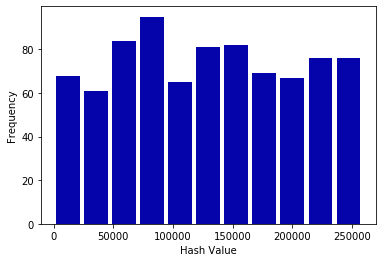

In [11]:
import matplotlib.pyplot as plt

hashtable = HashTableV2()

# Test 1: Simple Test
x = "Today is Monday'"
y = 'today'
assert hashtable.compare_substrings(x, y, 3) == [('tod', 0, 0), ('oda', 1, 1), ('day', 2, 2), ('day', 10, 2)]

# Test 2: Plagiarism Detection
x = "I had an original idea: hash tables can detect plagiarism."
y = "In part one of this assignment, I showed that hash tables can detect plagiarism"
assert hashtable.compare_substrings(x, y, 29) == [('hashtablescandetectplagiarism', 19, 36)]

# Test 3: Edge Cases
x = ""
y = ""
assert hashtable.compare_substrings(x, y, 3) == []

x = ',.;/'
y = ""
assert hashtable.compare_substrings(x, y, 1) == []

x = " "
y = " "
assert hashtable.compare_substrings(x, y, 1) == []

x = 1
y = 2
assert hashtable.compare_substrings(x, y, 1) == "x and y must both be strings"

# OTHER TESTS
# Uniformity of distribution Test 1
x = "In computing, a hash table (hash map) is a data structure that implements an associative array abstract data type, a structure that can map keys to values. A hash table uses a hash function to compute an index, also called a hash code, into an array of buckets or slots, from which the desired value can be found. During lookup, the key is hashed and the resulting hash indicates where the corresponding value is stored. Ideally, the hash function will assign each key to a unique bucket, but most hash table designs employ an imperfect hash function, which might cause hash collisions where the hash function generates the same index for more than one key. Such collisions are typically accommodated in some way. In a well-dimensioned hash table, the average cost (number of instructions) for each lookup is independent of the number of elements stored in the table. Many hash table designs also allow arbitrary insertions and deletions of key–value pairs, at (amortized[2]) constant average cost per operation.[3][4]"
y = "A basic requirement is that the function should provide a uniform distribution of hash values. A non-uniform distribution increases the number of collisions and the cost of resolving them. Uniformity is sometimes difficult to ensure by design, but may be evaluated empirically using statistical tests, e.g., a Pearson's chi-squared test for discrete uniform distributions.[6][7]"

indexes = []
hashtuples = hashtable.compare_substrings(x, y, 10, debug = True)
for tup in hashtuples:
    indexes.append(tup[0])

plt.hist(indexes, bins = 'auto', color='#0504aa',rwidth=0.85)
plt.xlabel("Hash Value")
plt.ylabel("Frequency")
plt.plot()

x: DQYdpx|RT$mMP,S6ag";E._@o=mgAp8\vce?8x-UT#+J,T.v\G@`6\f\@ly=wi.HjD&*>?0'q5$:QE:b?VIw"`\OS0ecPTGA&:YI'H@h6{(*o~@ML2v.y&!SI2r+s#ZaLXZw&?p]Lx<f8_U/g(3r})
y: k<]fFnP&;['L.]P-Dc.F${S7%dKZfI}t{9QE|^`&L4)mfz%qa-;5zZA(:Gm1^|M?;r(OST7c$'9WvVv+8O~@$cYeaW{p:%b\0GFrgObD7sHI({2mc+g~D!XL:/_5F&dM'xpg!k}\}]oZU5U#Z;z_?1
The load factor is: 0.022


[]

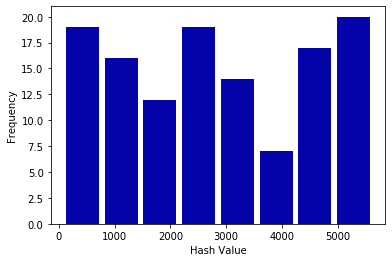

In [12]:
# Uniformity of distribution Test 2
import string
import random

chars = 150
x = "".join(random.choices(string.ascii_letters + 
                                       string.punctuation + 
                                       string.digits,
                                       k = chars))
y = "".join(random.choices(string.ascii_letters + 
                                       string.punctuation + 
                                       string.digits,
                                       k = chars))

print("x:", x)
print("y:", y)

indexes = []
hashtuples = hashtable.compare_substrings(x, y, 10, debug = True)
for tup in hashtuples:
    indexes.append(tup[0])

plt.hist(indexes, bins = 'auto', color='#0504aa',rwidth=0.85)
plt.xlabel("Hash Value")
plt.ylabel("Frequency")
plt.plot()

The load factor is: 0.085


[]

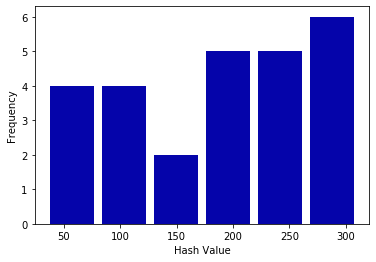

In [13]:
# Uniformity of distribution Test 3
x = '123456789abcdefghijklmnopqrstuvwxyz'
y = '123456789abcdefghijklmnopqrstuvwxyz'

indexes = []
hashtuples = hashtable.compare_substrings(x, y, 10, debug = True)
for tup in hashtuples:
    indexes.append(tup[0])

plt.hist(indexes, bins = 'auto', color='#0504aa',rwidth=0.85)
plt.xlabel("Hash Value")
plt.ylabel("Frequency")
plt.plot()

# Justifications
Most of the features in my implementation in part two are the same as those in part one (the data structures that I employ and my approach to table size). This justification section will instead focus on the changes that I made: the new hash function.

## Hash Function
The only significant change that I made to this version of the hashing algorithm was the use of a static hashing function, the functionality of much of which is similar to avoid duplication of effort. It removes illegal characters from the string, and then uses iterative string indexing to find all substrings of the specified length, and computing the hash value for each. I don't divide by ``mod len(table)`` until calling the ``compare_substrings()`` function, because the table size is calculated dynamically based on the expected number of substrings (taking open addressing into account).

For justification of ``APHash()``, see the section on it above (don't want to duplicate my explanation unnecessarily).

## Python Classes
Here, I avoided duplication of effort and code by using class inheritance, wherein one class can inherit the methods and attributes from another. I used an attribute to control the use of static hashing instead of rolling hashing, minimising the amount that I needed to adapt the code.


# Applications for Plagiarism
Plagiarism involves claiming someone else's work as your own. One common check for plagiarism is whether more than seven words are copied verbatim from another source without reference or quotation. If we assume that words have at least five characters on average, we could call the algorithm many different times with substring_length from around 30 up to around 100. If any of these searches returned a result, we would have to investigate further to determine if it was actually plagiarism (see Pitfalls)  


## Pitfalls
The specific pitfalls and challenges that emerge depend on the context in which the plagiarism detection algorithm would be used. For this analysis, we're assuming that we're using it to compare two typed and formatted paragraphs/essays/etc.

### Meaningful Substrings
One pitfall of our implementation is that comparing all substrings wastes a lot of time, because for the sake of plagiarism detection, we should only be examining those substrings that begin at the start of words and end at the end of words: students aren't going to be copying phrases and sentences that start halfway through a word. By restricting our subset of substrings, we could save significant computational time and space.

### Different types of plagiarism
There are many different types of plagiarism (e.g. presenting ideas as original when they're stolen, using images and other media without attribution, copying code segments). This system can only detect the type of plagiarism that involves exactly copying phrases and sentences.

### Commonly occuring substrings
In many cases, strings can share identical phrases or sentences without plagiarism being involved. For example, instructions in an assignment are on every student's paper, but clearly don't constitute plagiarism. This means this algorithm either has to be given only relevant text (e.g. student response sections) as strings, or 

### Quotations
The algorithmic strategy employed here doesn't ignore substrings when they are quotations. This means if two students use the same quote, the algorithm will pick up on it, leading to the identification of plagiarism where it doesn't exist. This would likely require human identification to fix, or the construction of a checking algorithm that looks to see whether the identified match occurs within a pair of quotation marks and dismisses it. 


### Brute Force Approach
The brute force version of the algorithm would involve first finding all substrings of a given length in ``Y`` (the text against which plagiarism is being judged), and then determining if these substrings exist in ``X`` (the potentially plagiarising  text). To make this comparison, we could slide a "window" of the appropriate length through ``X``, comparing each resulting substring with all of the substrings that we found from ``Y``.

The reason that this is so much slower than the hash table implementation is that, for each substring of ``X``, we have to compare it against all substrings in ``Y`` of the given length to see if it's a match.

For substrings of length ``k``, the number of substrings in ``x`` is given by ``len(x) - k + 1``. We can find each of these substrings in time ``O(1)`` using string indexing. This means the time complexity to find the substrings of ``x`` of length ``k`` is ``O(1)*(len(x) - k +1) == O(len(x) - k + 1)``. For a single substring of ``y``, we then need to compare against all substrings of ``x``. Comparison takes time ``O(1)``, so it takes ``O(1)*(len(x) - k +1) == O(len(x) - k + 1)`` to compare a single substring against those of ``x``. We then have to do this for all ``len(y) - k + 1`` substrings of ``y``.

In summary:

Finding substrings of ``x``: ``O(len(x) - k + 1)``
Comparing all subtrings of ``y`` with those of ``x``: ``(len(y) - k + 1)*O(len(x) - k + 1)``

This means overall time complexity is:
``O(len(x) - k + 1)`` + ``(len(y) - k + 1)*O(len(x) - k + 1)``

= ``(len(y) - k + 1)*O(len(x) - k + 1)``

This is far worse than the ``O(len(x))`` time complexity required for the hashing approach, since it involves multiplication by ``len(y)-k+1``. If we assume that ``len(y)`` is proportional to ``len(x)``, it ends up being roughly quadratic ``O(len(x)^2)``, as opposed to the the linear time complexity below.


# Complexity Analysis
Theoretically, the time complexity of the algorithm has three main components: the time taken to build the hash table for ``x``, the time taken to find all of the hashes for ``y``, and the time to search ``x``'s hash table using the hashes and substrings created from ``y``.


### Building the Hash Table for X

To build the hash table for ``x``, we have to compute the hash values for each substring in ``x``, and then insert them into the table. 

#### Computing Hash Values: Rolling Hash Values (Version 1)
When using rolling hashing to find substrings of length ``k`` from a string of length ``n``, the overall time complexity is ``O(n)``. This is because the first substring takes time ``O(k)`` to calculate, because you have to visit and compute ascii values for each character in the substring. For each of the subsequent substrings, we can find the hash value in ``O(1)``, because we only have to perform two operations, each of which has constant time complexity. We have to do this for all ``n-k`` remaining substrings, which has an overall time complexity of ``O(n-k)*O(1) = O(n-k)``.

Therefore, the overall time complexity is ``O(n-k) + O(k) == O(n-k+k) == O(n)``, where ``n = len(x)``

#### Computing Hash Values: Static Hash Values (Version 2)
The second implementation of the algorithm uses APHash() to compute hash values. This performs simple ``O(1)`` operations for each substring formed from ``O(x)``. For a single substring of length ``k``, the time complexity is therefore ``O(k)``. We have do this for each substring in ``x``, of which there rae ``n-k+1``. Therefore the overall time complexity of insertion for version 2 is ``O(n-k+1)*k = O(k(n-k+1))``.

#### Insertion
By design, the load factor of ``x``'s hash table is less than one (as long as the string isn't composed entirely of duplicate substrings of the given length), because the open-addressing structure and dynamic length means that on average each slot can't have more than one item in it. This means that insertion has a runtime of ``O(1/(1-alpha))`` for each entry. Therefore, the total time for insertion is ``O(1/(1-alpha))*n``, where ``n`` is the number of substring. For a given input string ``x`` (after processing out all illegal characters), the number of substrings of length ``k`` is equal to `` len(x) - k + 1``. Therefore the total time complexity for insertion is ``(len(x) - k + 1)*O(1/(1-alpha)) = O(1/(1-alpha)(len(x) - k + 1)``

### Finding Hashes for Y
The same logic applies for finding ``y``'s hash values: the overall time complexity for V1 is ``O(n)``, where ``n = len(y)``.

### Searching for Common Substrings
For each of the substrings in ``y``, we have to search the table. With no collisions, this would have a time complexity of ``O(1)``, unless there are a massive number of collisions. With the open addressing structure, we have to keep on recalculating the hash value and jumping indexes during search if the item isn't in the slots that we check (which only happens in the case of a collision or if it's not there at all). As long as the number of collisions remains low (proportional to ``O(1)``, search itself will have a time complexity of ``O(1)``. If the number of collisions is proportional to ``O(n)``, then an individual search will have time complexity ``O(n)``.

Below, I experimentally confirm that the number of collisions for both versions of the hash function remains extremely low (remaining around 2-3 collisions regardless of input size). This indicates that the overall time complexity of an individual search is ``O(1)``, and that the time complexity of search for all substrings of length ``k`` is ``O(1)*(len(y) - k + 1) == O(len(y) - k + 1)``.

# Summary
The asymptotic time complexity of the two versions differs only in the time required to calculate the hash values. For both, table insertion takes ``O(1/(1-alpha)(len(x) - k + 1)``, and searching for common substrings takes ``O(len(y) - k + 1)``.

For the rolling hashing used in version 1 of the code, the time complexity of computing hash values is ``O(len(x))``.

For the static hsahing used in version 2 of the code, the time complexity of computing hash values is ``O(k(len(x)-k+1))``.

Therefore, overall time complexity is:
V1: ``O(1/(1-alpha)(len(x) - k + 1) + O(len(y) - k + 1) +  O(len(x))``
V2: ``O(1/(1-alpha)(len(x) - k + 1) + O(len(y) - k + 1) +  O(k(len(x)-k+1))``

If we make some assumptions, we can simplify this further. First, because I use open addressing, my load factor will always be less than one, and therefore ``O(1/(1-alpha)) == O(1)``. Second, if we assume that ``k`` is proportional to ``O(1)`` rather than ``O(len(x))``, we can treat it as ``O(1)``. This is reasonable because, when looking for plagiarism, you're likely to be searching for shorter strings (around 30-50 characters) in a much larger text. With these assumptions, the time complexity simplifies to:

V1: ``O(len(x)) + O(len(y)) +  O(len(x))``
V2: ``O((len(x)) + O(len(y)) +  O(k(len(x))``

Thes are asymptotically the same! And, assuming that ``len(x)`` is proportional to ``len(y)``, they are linear:

Let ``len(x) == n`` and ``len(y) = k*len(x)``:

V1: ``O(n)+ kO(n) +  O(n) == (k+2)O(n) = O(n)``
V2: ``O(n) + kO(n) +  kO(n) == (2k+1)O(n) = O(n)``

# Empirical Validity
Given that the two algorithms have the same assymptotic time complexity, we need to look at empirical plots to determine which is better. Below, I average many different trials and find that the second version of the hashing algorithm takes far more time than the first. This most likely indicates that the time saved by implementing rolling hashing outweighs the benefits of using a hash function that creates a more uniform distribution. We can see this empirically too: the number of collisions is roughly equal for each implementation.

The plots below also validate many of my theoretical conclusions: the functions of time againt input size assume a linear functional form, as do the the number of collisions relative to input size. Table size grows quadratically with input size, which makes sense given my implementation of open addressing: the double hashing function tends to result in indices that are the square of the previous index.

*Note: originally I tried to do these tests with randomly generated characters, but found that very few matches were occurring, so I imported a dictionary of words and created input strings that were the concatenation of many randomly selected words so that matches were more commmon and the tests were more representative of the class's actual context*


# Space Complexity
It's difficult to theoretically determine the space requirements of the algorithms, because they dynamically change table length based on the hash values that are calculated, and those hash functions are unpredictable and heavily based on input. After performing empirical tests, it appears that both functions have exactly the same space complexity, in the realm of ``O(n^2)``, where ``n = len(x)``. Intuitively, this makes  sense -- the double hashed open addressing function tends to create hashes that are roughly equivalent to the squared term of the input hash. Given that both algorithms have the same space complexity, we can rely on other metrics such as time complexity and the number of collisions to conclude which strategy is more effective.

In [14]:
import time

# Initial Time and Space Tests

def timed_substring_comparison(x, y, substring_length, hashversion, verbose=False):
    """
    Times the execution of substring matching
    
    Parameters
    ----------
    x: str
        the first input string to be compared
    y: str
        the second input string to be compared
    substring_length: int
        the length of the substring matches to be searched for in x and y
    hashversion: 1 OR 2
        if 1, uses HashTable(); if 2, uses HashTableV2()
    verbose: Boolean
        switch variable; if True reports the load factor of the hash table
        
    Outputs
    -------
    end - start: numerical
        the time taken for the string matching method to execute
    """
    
    if hashversion == 1:
        hashtable = HashTable()
    elif hashversion == 2:
        hashtable = HashTableV2()
    else:
        return "Invalid hashversion value: please use either 1 or 2"
    
    start = time.time()
    hashtable.compare_substrings(x, y, substring_length, verbose=verbose)
    end = time.time()
    return end - start

def space_substring_comparison(x, y, substring_length, hashversion, verbose=False):
    """
    Returns the length of the hash table produced during string matching
    
    Parameters
    ----------
    x: str
        the first input string to be compared
    y: str
        the second input string to be compared
    substring_length: int
        the length of the substring matches to be searched for in x and y
    hashversion: 1 OR 2
        if 1, uses HashTable(); if 2, uses HashTableV2()
    verbose: Boolean
        switch variable; if True reports the load factor of the hash table
        
    Outputs
    -------
    len(xtable): int
        the length of the array used to represent the hash table
    """
    if hashversion == 1:
        hashtable = HashTable()
    elif hashversion == 2:
        hashtable = HashTableV2()
    else:
        return "Invalid hashversion value: please use either 1 or 2"
    
    xtable = hashtable.compare_substrings(x, y, substring_length, xswitch = True, verbose=verbose)
    return len(xtable)

def collision_substring_comparison(x, y, substring_length, 
                                   hashversion, verbose=False):
    """
    Returns the number of collisions that occurred during string matching
    
    Parameters
    ----------
    x: str
        the first input string to be compared
    y: str
        the second input string to be compared
    substring_length: int
        the length of the substring matches to be searched for in x and y
    hashversion: 1 OR 2
        if 1, uses HashTable(); if 2, uses HashTableV2()
    verbose: Boolean
        switch variable; if True reports the load factor of the hash table
        
    Outputs
    -------
    collisions: int
        the number of collisions that occured during string matching
    """
    if hashversion == 1:
        hashtable = HashTable()
    elif hashversion == 2:
        hashtable = HashTableV2()
    else:
        return "Invalid hashversion value: please use either 1 or 2"
    
    collisions = hashtable.compare_substrings(x, 
                                              y, 
                                              substring_length, 
                                              collision_count = True, 
                                              verbose=verbose)
    return collisions


# TESTS
# Test 1: Simple Test
x = "Today is Monday'"
y = 'today'
print(f"Time taken for v1: {timed_substring_comparison(x, y, 3, 1)}")
print(f"Time taken for v2: {timed_substring_comparison(x, y, 3, 2)}")
print(f"Space required for v1: {space_substring_comparison(x, y, 3, 1)}")
print(f"Space required for v2: {space_substring_comparison(x, y, 3, 2)}")
print("\n")

# Test 2: Plagiarism Detection
x = "I had an original idea: hash tables can detect plagiarism."
y = "In part one of this assignment, I showed that hash tables can detect plagiarism"
print(f"Time taken for v1: {timed_substring_comparison(x, y, 29, 1)}")
print(f"Time taken for v2: {timed_substring_comparison(x, y, 29, 2)}")
print(f"Space required for v1: {space_substring_comparison(x, y, 3, 1)}")
print(f"Space required for v2: {space_substring_comparison(x, y, 3, 2)}")
print("\n")

# Test 3: Edge Cases
x = ""
y = ""
print(f"Time taken for v1: {timed_substring_comparison(x, y, 1, 1)}")
print(f"Time taken for v2: {timed_substring_comparison(x, y, 1, 2)}")
print(f"Space required for v1: {space_substring_comparison(x, y, 3, 1)}")
print(f"Space required for v2: {space_substring_comparison(x, y, 3, 2)}")
print("\n")

x = ',.;/'
y = ""
print(f"Time taken for v1: {timed_substring_comparison(x, y, 1, 1)}")
print(f"Time taken for v2: {timed_substring_comparison(x, y, 1, 2)}")
print(f"Space required for v1: {space_substring_comparison(x, y, 3, 1)}")
print(f"Space required for v2: {space_substring_comparison(x, y, 3, 2)}")
print("\n")

x = 1
y = 2
print(f"Time taken for v1: {timed_substring_comparison(x, y, 1, 1)}")
print(f"Time taken for v2: {timed_substring_comparison(x, y, 1, 2)}")
print(f"Space required for v1: {space_substring_comparison(x, y, 3, 1)}")
print(f"Space required for v2: {space_substring_comparison(x, y, 3, 2)}")
print("\n")

Time taken for v1: 8.296966552734375e-05
Time taken for v2: 8.606910705566406e-05
Space required for v1: 69
Space required for v2: 49


Time taken for v1: 0.0002741813659667969
Time taken for v2: 0.0012028217315673828
Space required for v1: 842
Space required for v2: 836


Time taken for v1: 1.6927719116210938e-05
Time taken for v2: 1.1682510375976562e-05
Space required for v1: 0
Space required for v2: 1


Time taken for v1: 1.7881393432617188e-05
Time taken for v2: 8.821487426757812e-06
Space required for v1: 0
Space required for v2: 1


Time taken for v1: 1.9073486328125e-06
Time taken for v2: 9.5367431640625e-07
Space required for v1: 28
Space required for v2: 28




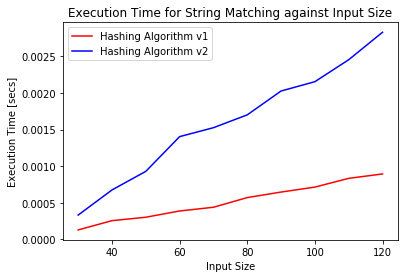

In [16]:
# TEST ONE: EXECUTION TIME FOR V1 AND V2

import matplotlib.pyplot as plt
import random
import string
import time

# importing a dictionary
import requests
word_site = "https://www.mit.edu/~ecprice/wordlist.10000"
response = requests.get(word_site)
words = response.content.splitlines()

timev1 = []
timev2 = []
for char_length in range(30, 130, 10):
    # lists for holding trial outcomes
    trial_timev1 = []
    trial_timev2 = []
    
    for trial in range(10):
        """
        This section of the code chooses random words from a dictionary and 
        concatenates them, shortening them to the length specified in char_length.
        This means the inputs more closely approximate the actual context of the 
        problem (plagiarism in student submissions), whereas the random
        characters that I originally used did not.
        """
        x = "".join([i.decode("utf-8") for i in random.choices(words, k = 50)])
        x = x[:char_length]  
        y = "".join([i.decode("utf-8") for i in random.choices(words, k = 50)])
        y = y[:char_length]
        
        trial_timev1.append(timed_substring_comparison(x, y, 20, 1))
        trial_timev2.append(timed_substring_comparison(x, y, 20, 2))
    
    # average trial outcomes and append to overall lists
    timev1.append(sum(trial_timev1)/len(trial_timev1))
    timev2.append(sum(trial_timev2)/len(trial_timev2))

x_axis = [i for i in range(30, 130, 10)]

plt.plot(x_axis, timev1, color='red', label="Hashing Algorithm v1")
plt.plot(x_axis, timev2, color='blue', label="Hashing Algorithm v2")
plt.xlabel('Input Size')
plt.ylabel("Execution Time [secs]")
plt.title("Execution Time for String Matching against Input Size")
plt.legend()
    
        

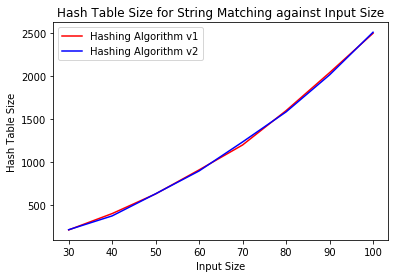

In [17]:
import matplotlib.pyplot as plt
import random
import string
import time

import requests
word_site = "https://www.mit.edu/~ecprice/wordlist.10000"
response = requests.get(word_site)
words = response.content.splitlines()

spacev1 = []
spacev2 = []
for char_length in range(30, 110, 10):
    # lists for holding trial outcomes
    trial_spacev1 = []
    trial_spacev2 = []
    for trial in range(5):
        """
        This section of the code chooses random words from a dictionary and 
        concatenates them, shortening them to the length specified in char_length.
        This means the inputs more closely approximate the actual context of the 
        problem (plagiarism in student submissions), whereas the random
        characters that I originally used did not.
        """
        x = "".join([i.decode("utf-8") for i in random.choices(words, k = 50)])
        x = x[:char_length]  
        y = "".join([i.decode("utf-8") for i in random.choices(words, k = 50)])
        y = y[:char_length]
        
        trial_spacev1.append(space_substring_comparison(x, y, 20, 1))
        trial_spacev2.append(space_substring_comparison(x, y, 20, 2))
    
    # average trial outcomes and append to overall lists
    spacev1.append(sum(trial_spacev1)/len(trial_spacev1))
    spacev2.append(sum(trial_spacev2)/len(trial_spacev2))

x_axis = [i for i in range(30, 110, 10)]

plt.plot(x_axis, spacev1, color='red', label="Hashing Algorithm v1")
plt.plot(x_axis, spacev2, color='blue', label="Hashing Algorithm v2")
plt.xlabel('Input Size')
plt.ylabel("Hash Table Size")
plt.title("Hash Table Size for String Matching against Input Size")
plt.legend()
     
        

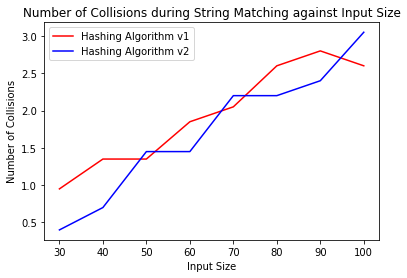

In [18]:
import matplotlib.pyplot as plt
import random
import string
import time

import requests
word_site = "https://www.mit.edu/~ecprice/wordlist.10000"
response = requests.get(word_site)
words = response.content.splitlines()

colv1 = []
colv2 = []
for char_length in range(30, 110, 10):
    # lists for holding trial outcomes
    trial_colv1 = []
    trial_colv2 = []
    for trial in range(20):
        """
        This section of the code chooses random words from a dictionary and 
        concatenates them, shortening them to the length specified in char_length.
        This means the inputs more closely approximate the actual context of the 
        problem (plagiarism in student submissions), whereas the random
        characters that I originally used did not.
        """
        x = "".join([i.decode("utf-8") for i in random.choices(words, k = 50)])
        x = x[:char_length]  
        y = "".join([i.decode("utf-8") for i in random.choices(words, k = 50)])
        y = y[:char_length]
        
        trial_colv1.append(collision_substring_comparison(x, y, 20, 1))
        trial_colv2.append(collision_substring_comparison(x, y, 20, 2))
    
    # average trial outcomes and append to overall lists
    colv1.append(sum(trial_colv1)/len(trial_colv1))
    colv2.append(sum(trial_colv2)/len(trial_colv2))

x_axis = [i for i in range(30, 110, 10)]

plt.plot(x_axis, colv1, color='red', label="Hashing Algorithm v1")
plt.plot(x_axis, colv2, color='blue', label="Hashing Algorithm v2")
plt.xlabel('Input Size')
plt.ylabel("Number of Collisions")
plt.title("Number of Collisions during String Matching against Input Size")

plt.legend()
     
        